In [1]:
%%capture
%pip install copulas==0.8.0

In [2]:
!gdown 1LK03a5IbPiV6RosdTR15gjZpLIg3YnBl

Downloading...
From: https://drive.google.com/uc?id=1LK03a5IbPiV6RosdTR15gjZpLIg3YnBl
To: /content/TrainDataset2023.xls
100% 867k/867k [00:00<00:00, 90.4MB/s]


# Required Libs

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [4]:
import pandas as pd
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score

In [73]:
df = pd.read_excel('/content/TrainDataset2023.xls')
df.drop(['ID'], axis=1, inplace = True) # Drop ID # 'RelapseFreeSurvival (outcome)'

# Drop NaN vals
for col in df.columns:
  df.drop(df[df[col] == 999].index, inplace=True)

dff = df[df.columns].reset_index(drop=True)

In [74]:
# Categorical Features (9 features)
# Numerical Features (108 features)

dff.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


# Feature Selection

In [536]:
def normalize_data(data):
  """Normalizes data using a lambda function."""

  # subtract the mean and divide by the standard deviation
  return (data - data.mean()) / data.std()

def to_list_normalization(data1):
    data2 = data1.apply(normalize_data, axis=0)

    return data2

In [537]:
df_train, df_test = train_test_split(dff, test_size=0.2, random_state=123)

df_train = df_train[df_train.columns].reset_index(drop=True)
df_val   = df_train[0:40]
df_train = df_train[40:]
df_test  = df_test[df_test.columns].reset_index(drop=True)

In [538]:
df_train_fea = df_train[df_train.columns[2:]] # Exclude Lables
df_val_fea   = df_val[df_train.columns[2:]]
df_test_fea  = df_test[df_test.columns[2:]] # Exclude Lables

ALL_Features = list(df_train_fea.columns)
Categorical_Features = ['ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType',
                        'LNStatus', 'TumourStage']
Numerical_Features = list(set(ALL_Features) - set(Categorical_Features)) # Extract Numerical Features

df_train_categorical_fea = df_train_fea[Categorical_Features]
df_train_num_fea   = df_train_fea[Numerical_Features]

df_val_categorical_fea = df_val[Categorical_Features]
df_val_num_fea   = df_val[Numerical_Features]

df_test_categorical_fea = df_test_fea[Categorical_Features]
df_test_num_fea   = df_test_fea[Numerical_Features]

In [539]:
# Normalise Numerical Features
df_train_num_fea_nor = to_list_normalization(df_train_num_fea)
df_val_num_fea_nor = to_list_normalization(df_val_num_fea)
df_test_num_fea_nor  = to_list_normalization(df_test_num_fea)

In [540]:
df_train_nor = pd.concat([df_train_categorical_fea, df_train_num_fea_nor], axis=1)
df_val_nor   = pd.concat([df_val_categorical_fea, df_val_num_fea], axis=1)
df_test_nor  = pd.concat([df_test_categorical_fea, df_test_num_fea_nor], axis=1)

Data_Train   = df_train_nor.values.tolist()
Data_val     = df_val_nor.values.tolist()
Data_Test    = df_test_nor.values.tolist()

In [541]:
y_train_PCR = df_train['pCR (outcome)'].values.tolist()
y_train_RFS = df_train['RelapseFreeSurvival (outcome)'].values.tolist()

y_val_PCR = df_val['pCR (outcome)'].values.tolist()
y_val_RFS = df_val['RelapseFreeSurvival (outcome)'].values.tolist()

y_test_PCR = df_test['pCR (outcome)'].values.tolist()
y_test_RFS = df_test['RelapseFreeSurvival (outcome)'].values.tolist()

In [542]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(Data_Train, y_train_PCR)

SelectFromModel(estimator=RandomForestClassifier())

In [543]:
# Feature selection using RL
Importance = []
Importance_idx = []
Feature_Values = []
for idx, boo in enumerate(sel.get_support()) :
  if boo == True:
    Importance.append((df_train_nor.columns[idx], sel.estimator_.feature_importances_[idx]) )
    Importance_idx.append(idx)
    Feature_Values.append(sel.estimator_.feature_importances_[idx])

IMPORTANCE = []
Sort = sorted(Feature_Values, reverse=True)
for val in Sort:
  for tup in Importance:
    if val == tup[1]:
      IMPORTANCE.append((tup[0], val))

dict(IMPORTANCE)

{'original_firstorder_Energy': 0.01965470671687688,
 'original_glszm_SmallAreaEmphasis': 0.019303558310982783,
 'original_shape_Maximum2DDiameterRow': 0.01893518631981532,
 'original_glszm_SmallAreaLowGrayLevelEmphasis': 0.018599214102626348,
 'original_firstorder_RobustMeanAbsoluteDeviation': 0.017538002370692776,
 'original_firstorder_Median': 0.017218860858747763,
 'original_gldm_DependenceNonUniformityNormalized': 0.01636336769300289,
 'original_glszm_ZoneEntropy': 0.015298616003921232,
 'original_glszm_SmallAreaHighGrayLevelEmphasis': 0.014934492164051962,
 'original_glszm_SizeZoneNonUniformityNormalized': 0.014782367632476734,
 'original_firstorder_Kurtosis': 0.014688944483118672,
 'original_firstorder_RootMeanSquared': 0.014224901233772203,
 'original_shape_Flatness': 0.013993726776867953,
 'original_glrlm_RunLengthNonUniformity': 0.013846419891360564,
 'original_firstorder_Range': 0.013837467919826351,
 'original_gldm_GrayLevelNonUniformity': 0.013765893751467194,
 'Age': 0.013

In [544]:
# Prepare Labels
# Label_Test  = np.array(Label_Test)
df_train_selected_nor = df_train_nor[list(dict(IMPORTANCE))[0:10]]
df_val_selected_nor   = df_val_nor[list(dict(IMPORTANCE))[0:10]]
df_test_selected_nor  = df_test_nor[list(dict(IMPORTANCE))[0:10]]

In [545]:
df_test_selected_nor.to_csv('/content/test_normalise.csv', index=False)

In [546]:
# # Check Imbalance
# plt.figure(figsize = (3, 2))

# df_train_selected_nor['pCR (outcome)'].value_counts() # Not Balanced
# sns.countplot(x="pCR (outcome)", data=df)

# First Model with unsolving Imbalance

In [547]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            #BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
            BCE_loss = torch.nn.cross_entropy(inputs, targets, reduce=None)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=None)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [548]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

scores = []
# kfold = KFold(n_splits=5)
class Datasett(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x.clone().detach(), y.clone().detach().type(torch.LongTensor) # .to(torch.float32)

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()

        self.cf1 = nn.Linear(10, 4)
        self.cf2 = nn.Linear(4, 4)
        self.cf3 = nn.Linear(4, 2)

        self.relu    = nn.ReLU()

        self.batchnorm1 = nn.BatchNorm1d(4)

    def forward(self, x):
        x  = self.relu(self.batchnorm1(self.cf1(x)))
        x  = self.relu(self.cf2(x))
        x  = self.cf3(x)

        return x

X_train = torch.tensor(df_train_selected_nor.values, dtype=torch.float32)
X_val = torch.tensor(df_val_selected_nor.values, dtype=torch.float32)
X_test  = torch.tensor(df_test_selected_nor.values, dtype=torch.float32)

y_train = torch.tensor(y_train_PCR, dtype=torch.float32)
y_val   = torch.tensor(y_val_PCR, dtype=torch.float32)
y_test  = torch.tensor(y_test_PCR, dtype=torch.float32)

train_dataset = Datasett(data = X_train, targets = y_train)
val_dataset  = Datasett(data = X_val,  targets = y_val)
test_dataset = Datasett(data = X_test,  targets = y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

model = MLPClassifier()
model = model.to(device)

criterion = nn.CrossEntropyLoss() # FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6,
                                     patience=3, min_lr= 0.0001 ,verbose = True)
# optimizer.zero_grad()

In [549]:
def MLP(model, criterion, optimizer, scheduler, epochs, train_loader, test_loader):
    val_loss_his = []
    train_loss_his = []
    count = 1

    train_his_losses = []
    val_his_losses = []
    for eph in range(epochs):
        loss_epoch_train = []
        loss_epoch_val = []

        Train_Correct = 0
        total_train = 0
        model.train()
        for b, (X_train, y_train) in enumerate(train_loader):
            optimizer.zero_grad()

            X_train, y_train = X_train.to(device), y_train.to(device)

            output = model(X_train)
            y_pred = output
            y_prd  = torch.argmax(y_pred, 1)

            Train_Correct += torch.sum(y_prd == y_train)

            total_train += y_train.shape[0]
            # print(y_prd)

            loss = criterion(y_pred.cpu(), y_train.cpu())
            # print(loss)

            loss_epoch_train.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss_his.append(np.mean(loss_epoch_train))
        train_acc = Train_Correct/total_train

        # Run the validation batches
        Val_Correct = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for b, (X_val, y_val) in enumerate(val_loader):
                X_val, y_val = X_val.to(device), y_val.to(device)

                out_val = model(X_val)
                y_prd_val  = torch.argmax(out_val, 1)

                Val_Correct += torch.sum(y_prd_val == y_val)

                total_val += y_val.shape[0]

                loss = criterion(out_val.cpu(), y_val.cpu())

                loss_epoch_val.append(loss.item())

            val_loss_his.append(np.mean(loss_epoch_val))
            scheduler.step(np.mean(loss_epoch_val))
            val_acc = Val_Correct/total_val

        if eph > 1:
            if np.mean(loss_epoch_val) < min(val_loss_his[0:-1]):
                count = 0
                print(str(eph) + ' Val loss improve form!! :' + str(min(val_loss_his[0:-1])) + ' to ' + str(np.mean(loss_epoch_val)) )
                # print('------------------Save Model!----------------')
                # torch.save(model.state_dict(), '/content/BestLSTM.pt')

            if np.mean(loss_epoch_val) > min(val_loss_his[0:-1]):
                print('Val loss is not improve form ' + str(min(val_loss_his))  )
                count += 1
                if count == 10:
                    print('Stop Training')

                    return float(val_acc), model

                    break

In [552]:
epochs = 100
model = MLPClassifier()

# model.load_state_dict(torch.load('/content/BestLSTM.pt'))
acc, model = MLP(model, criterion, optimizer, scheduler, epochs, train_loader, val_loader)

model.eval()
with torch.no_grad():
  prd = model(X_test)

balanced_accuracy_score(y_test, np.argmax(prd, axis=1))

Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Val loss is not improve form 268.2850036621094
Stop Training


0.5

# Soving Imbalace Class using Copula

In [553]:
import copulas
from copulas.datasets import sample_trivariate_xyz

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 272 samples in 0.001s...
[t-SNE] Computed neighbors for 272 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 272 / 272
[t-SNE] Mean sigma: 1.089189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.945988
[t-SNE] KL divergence after 1000 iterations: 0.683071


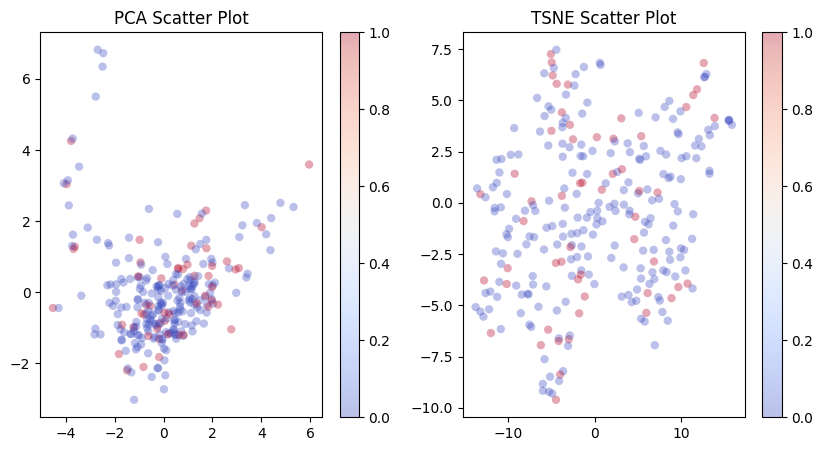

In [554]:
X = df_train_selected_nor[df_train_selected_nor.columns[1:]].values # Exclude Labels From DataFrame
Labels = y_train_PCR

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')

plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

In [558]:
from copulas.visualization import scatter_3d
from copulas.multivariate import GaussianMultivariate
# scatter_3d(df)

# Train our gaussian copula
df_train_selected_nor.insert(0, 'pCR (outcome)', df_train['pCR (outcome)'].values.tolist())
df_test_selected_nor.insert(0, 'pCR (outcome)', df_test['pCR (outcome)'].values.tolist())

copula = GaussianMultivariate()
copula.fit(df_train_selected_nor)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.10/dist-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/usr/local/lib/python3.10/dist-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration i

In [609]:
synthetic_data = copula.sample(num_rows=1500)
synthetic_data.head()

,pCR (outcome),original_firstorder_Energy,original_glszm_SmallAreaEmphasis,original_shape_Maximum2DDiameterRow,original_glszm_SmallAreaLowGrayLevelEmphasis,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Median,original_gldm_DependenceNonUniformityNormalized,original_glszm_ZoneEntropy,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized
0,-0.204110,3.421937,-0.563240,0.775915,-0.505129,1.662135,4.067921,-0.299589,-0.984461,-0.778823,0.462381
1,-0.157183,-0.288560,1.797949,-0.631185,1.563049,-0.251095,-0.648956,0.326832,-0.443135,2.476131,1.210160
2,0.005900,-0.210603,-0.410700,0.610159,-0.534115,-0.520693,-0.604584,0.415199,1.316499,-0.139550,-0.746849
3,-0.116839,-0.366661,0.265463,-1.337307,0.224906,0.957303,0.044446,-1.509935,-3.244489,0.260604,6.449764
4,-0.365789,-0.177538,-2.015441,-0.175199,-2.005357,-0.505357,1.157767,0.798083,0.820925,-2.078037,-0.844318


In [610]:
synthetic_dataa = synthetic_data[abs(1 - synthetic_data['pCR (outcome)']) <= 0.1]
synthetic_dataa = synthetic_dataa.reset_index(drop=True)
synthetic_dataa['pCR (outcome)'] = synthetic_dataa['pCR (outcome)'].apply(lambda x: 1)

In [611]:
df_upsampling = pd.concat([df_train_selected_nor, synthetic_dataa])
df_upsampling

,pCR (outcome),original_firstorder_Energy,original_glszm_SmallAreaEmphasis,original_shape_Maximum2DDiameterRow,original_glszm_SmallAreaLowGrayLevelEmphasis,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Median,original_gldm_DependenceNonUniformityNormalized,original_glszm_ZoneEntropy,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized
40,0,-0.208386,0.808635,-0.311513,0.814760,-0.335295,-0.138859,0.631076,-0.091693,0.759073,0.224440
41,0,-0.142293,0.336494,-0.196025,0.342477,0.547222,0.760667,0.412690,0.293305,0.302593,-0.204495
42,0,-0.300827,0.067375,-0.324547,0.073279,0.932578,-0.083667,-0.398646,0.667605,0.042393,-0.454872
43,0,0.077852,0.438753,0.248230,0.444768,1.148289,0.640274,0.209798,0.571563,0.401457,-0.180488
44,0,-0.308927,0.028620,-0.699614,0.034512,-0.136123,0.682350,-0.563384,0.242816,0.004924,-0.375495
...,...,...,...,...,...,...,...,...,...,...,...
155,1,-0.342292,1.080347,-0.726415,1.056915,0.223387,-0.078723,-1.568649,-1.048749,1.077245,0.501250
156,1,-0.196107,0.316468,-0.430656,0.445177,1.883862,0.734832,-0.551814,-0.630756,-0.045887,0.184959
157,1,-0.089861,-0.781737,0.506725,-0.731332,0.517886,1.353450,-1.022300,0.568952,-1.032643,-0.484455
158,1,-0.297769,0.577534,-0.282420,0.630938,-0.663845,2.079497,-0.966286,-1.238661,0.346398,0.916261


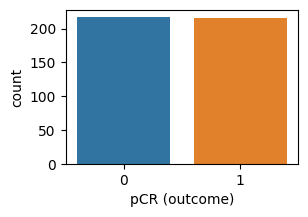

In [612]:
# Check Imbalance
plt.figure(figsize = (3, 2))

df_upsampling['pCR (outcome)'].value_counts() # Not Balanced
sns.countplot(x="pCR (outcome)", data=df_upsampling)


df_tsne = df_upsampling.drop('pCR (outcome)', axis=1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.001s...
[t-SNE] Computed neighbors for 432 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.987272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.205284
[t-SNE] KL divergence after 1000 iterations: 0.797678


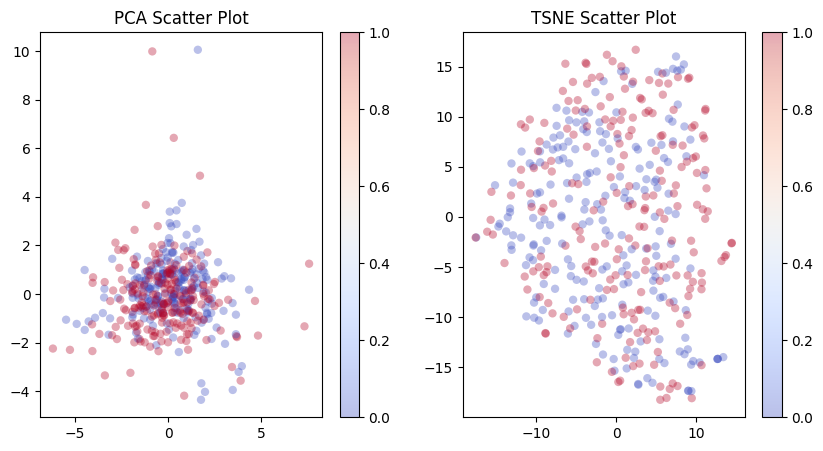

In [613]:
# Turn dataframe into arrays
DF_reduc = df_upsampling.drop('pCR (outcome)', axis=1)
DF_reduc = to_list_normalization(DF_reduc)

X = DF_reduc.values

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X)

Labels = df_upsampling['pCR (outcome)']

# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')

plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = Labels,
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

# Model 2 with copula

In [614]:
X_train.shape

torch.Size([343, 10])

In [615]:
df_test_selected_nor.columns

Index(['pCR (outcome)', 'original_firstorder_Energy',
       'original_glszm_SmallAreaEmphasis',
       'original_shape_Maximum2DDiameterRow',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_Median',
       'original_gldm_DependenceNonUniformityNormalized',
       'original_glszm_ZoneEntropy',
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized'],
      dtype='object')

In [616]:
X_train = torch.tensor(DF_reduc[40:].values, dtype=torch.float32)
X_val   = torch.tensor(DF_reduc[0:40].values, dtype=torch.float32)
X_test  = torch.tensor(df_test_selected_nor[df_test_selected_nor.columns[1:]].values, dtype=torch.float32)

y_train = torch.tensor(df_upsampling['pCR (outcome)'].values[40:], dtype=torch.float32)
y_val = torch.tensor(df_upsampling['pCR (outcome)'].values[0:40], dtype=torch.float32)
y_test  = torch.tensor(df_test_selected_nor['pCR (outcome)'], dtype=torch.float32)

train_dataset = Datasett(data = X_train, targets = y_train)
val_dataset   = Datasett(data = X_val, targets = y_val)
test_dataset  = Datasett(data = X_test,  targets = y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss() # FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6,
                                     patience=3, min_lr= 0.0001 ,verbose = True)

In [619]:
epochs = 200
model_gen = MLPClassifier()

# model.load_state_dict(torch.load('/content/BestLSTM.pt'))
acc, model_gen = MLP(model_gen, criterion, optimizer, scheduler, epochs, train_loader, val_loader)

model.eval()
with torch.no_grad():
  prd = model_gen(X_test)

balanced_accuracy_score(y_test, np.argmax(prd, axis=1))

2 Val loss improve form!! :0.6256449222564697 to 0.6248304843902588
3 Val loss improve form!! :0.6248304843902588 to 0.6237412095069885
4 Val loss improve form!! :0.6237412095069885 to 0.6227999329566956
5 Val loss improve form!! :0.6227999329566956 to 0.6218916773796082
6 Val loss improve form!! :0.6218916773796082 to 0.6208764910697937
7 Val loss improve form!! :0.6208764910697937 to 0.6199157238006592
8 Val loss improve form!! :0.6199157238006592 to 0.6190800666809082
9 Val loss improve form!! :0.6190800666809082 to 0.6188797950744629
10 Val loss improve form!! :0.6188797950744629 to 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val loss is not improve form 0.6180585622787476
Val

0.5151209677419355